In [40]:
# =====================================
# HEART DISEASE PREDICTION PROJECT
# COMPLETE NOTEBOOK
# =====================================

# ===============================
# Imports
# ===============================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

import joblib

%matplotlib inline

plt.rcParams['figure.dpi'] = 150
sns.set(style="darkgrid")

# ===============================
# Load Dataset
# ===============================



In [41]:
# ===============================
# Load Dataset
# ===============================


df = pd.read_csv('/content/heart (1).csv')

print(df.head())
print(df.info())
print(df.isnull().sum())



   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5 

In [42]:
# ===============================
# Feature Types
# ===============================

continuous_features = ['age','trestbps','chol','thalach','oldpeak']

categorical_features = [col for col in df.columns if col not in continuous_features]

# Convert categorical to object
df[categorical_features] = df[categorical_features].astype('object')



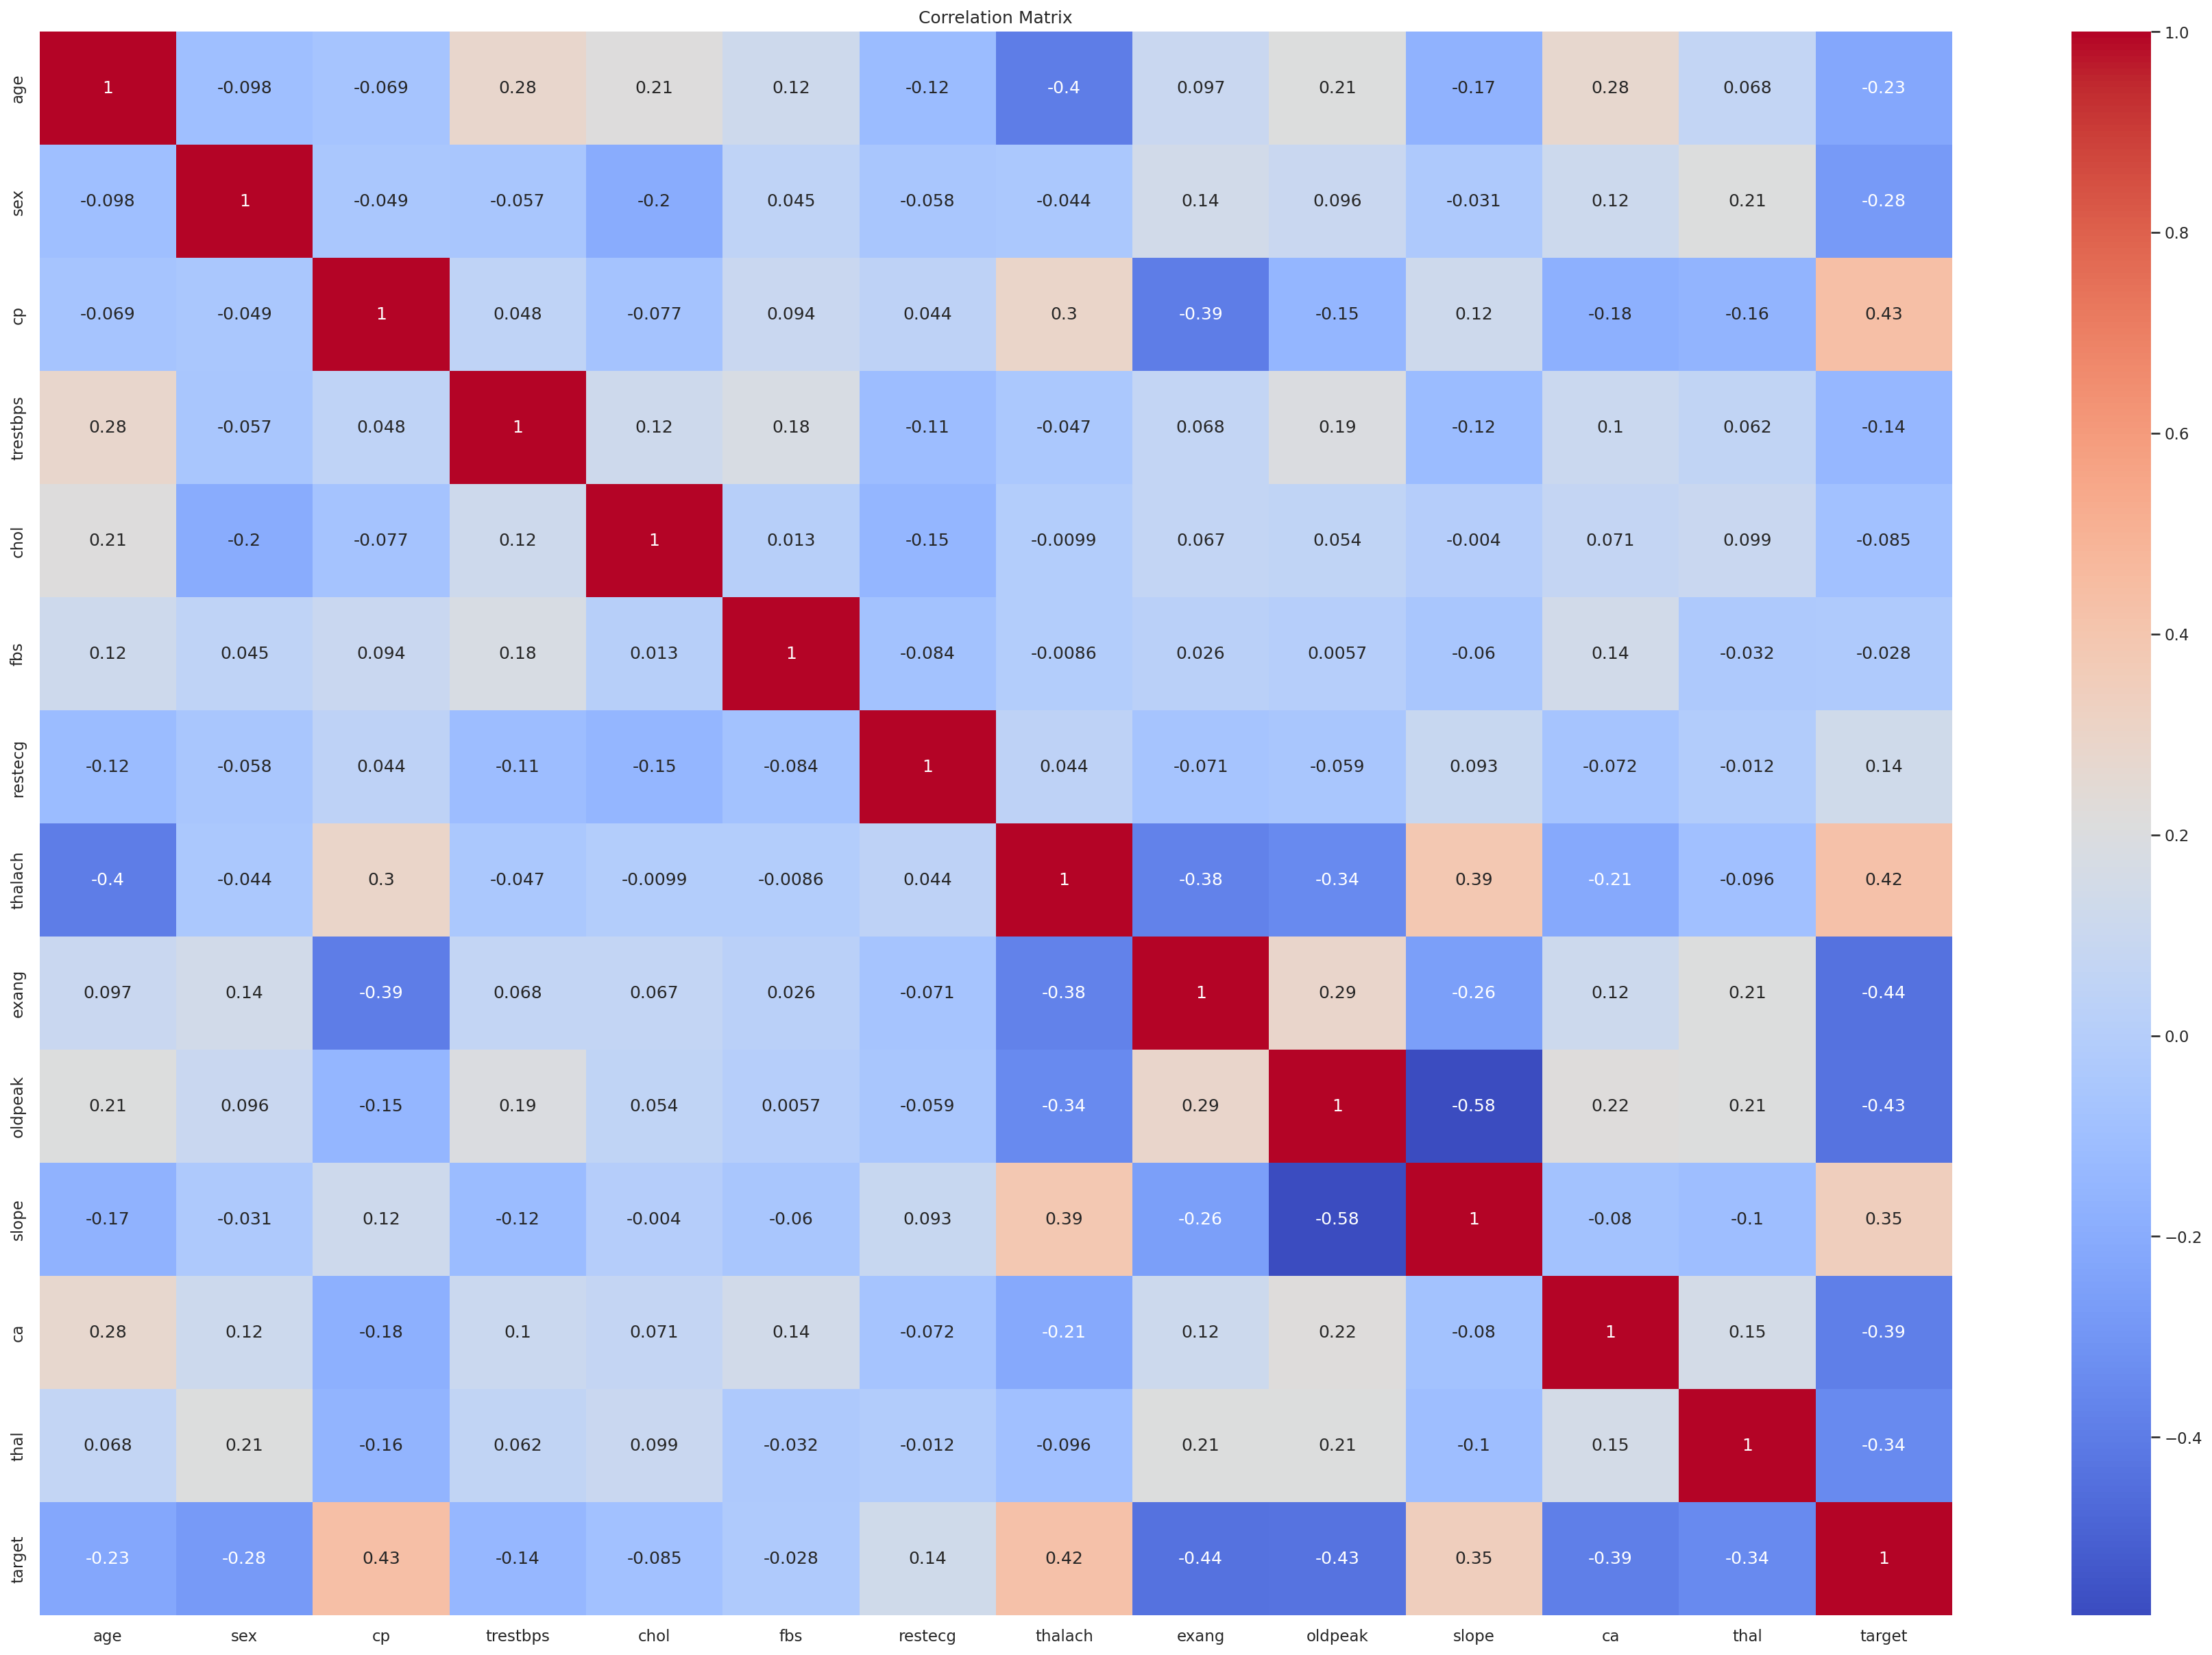

In [43]:
# ===============================
# EDA - Correlation
# ===============================

plt.figure(figsize=(30,20))
sns.heatmap(df.astype(float).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()



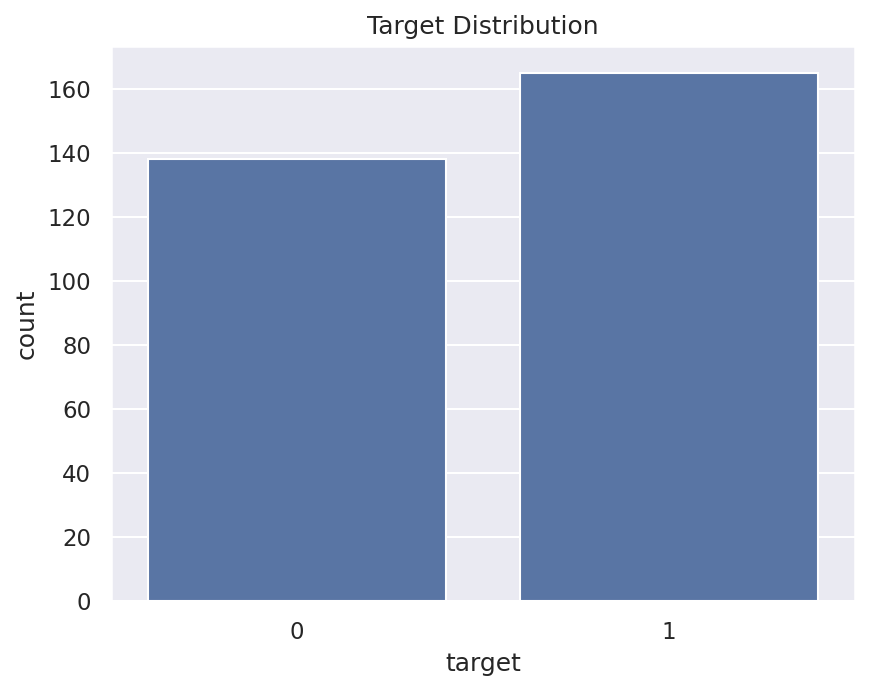

In [44]:
# ===============================
# Target Distribution
# ===============================

sns.countplot(x='target', data=df)
plt.title("Target Distribution")
plt.show()



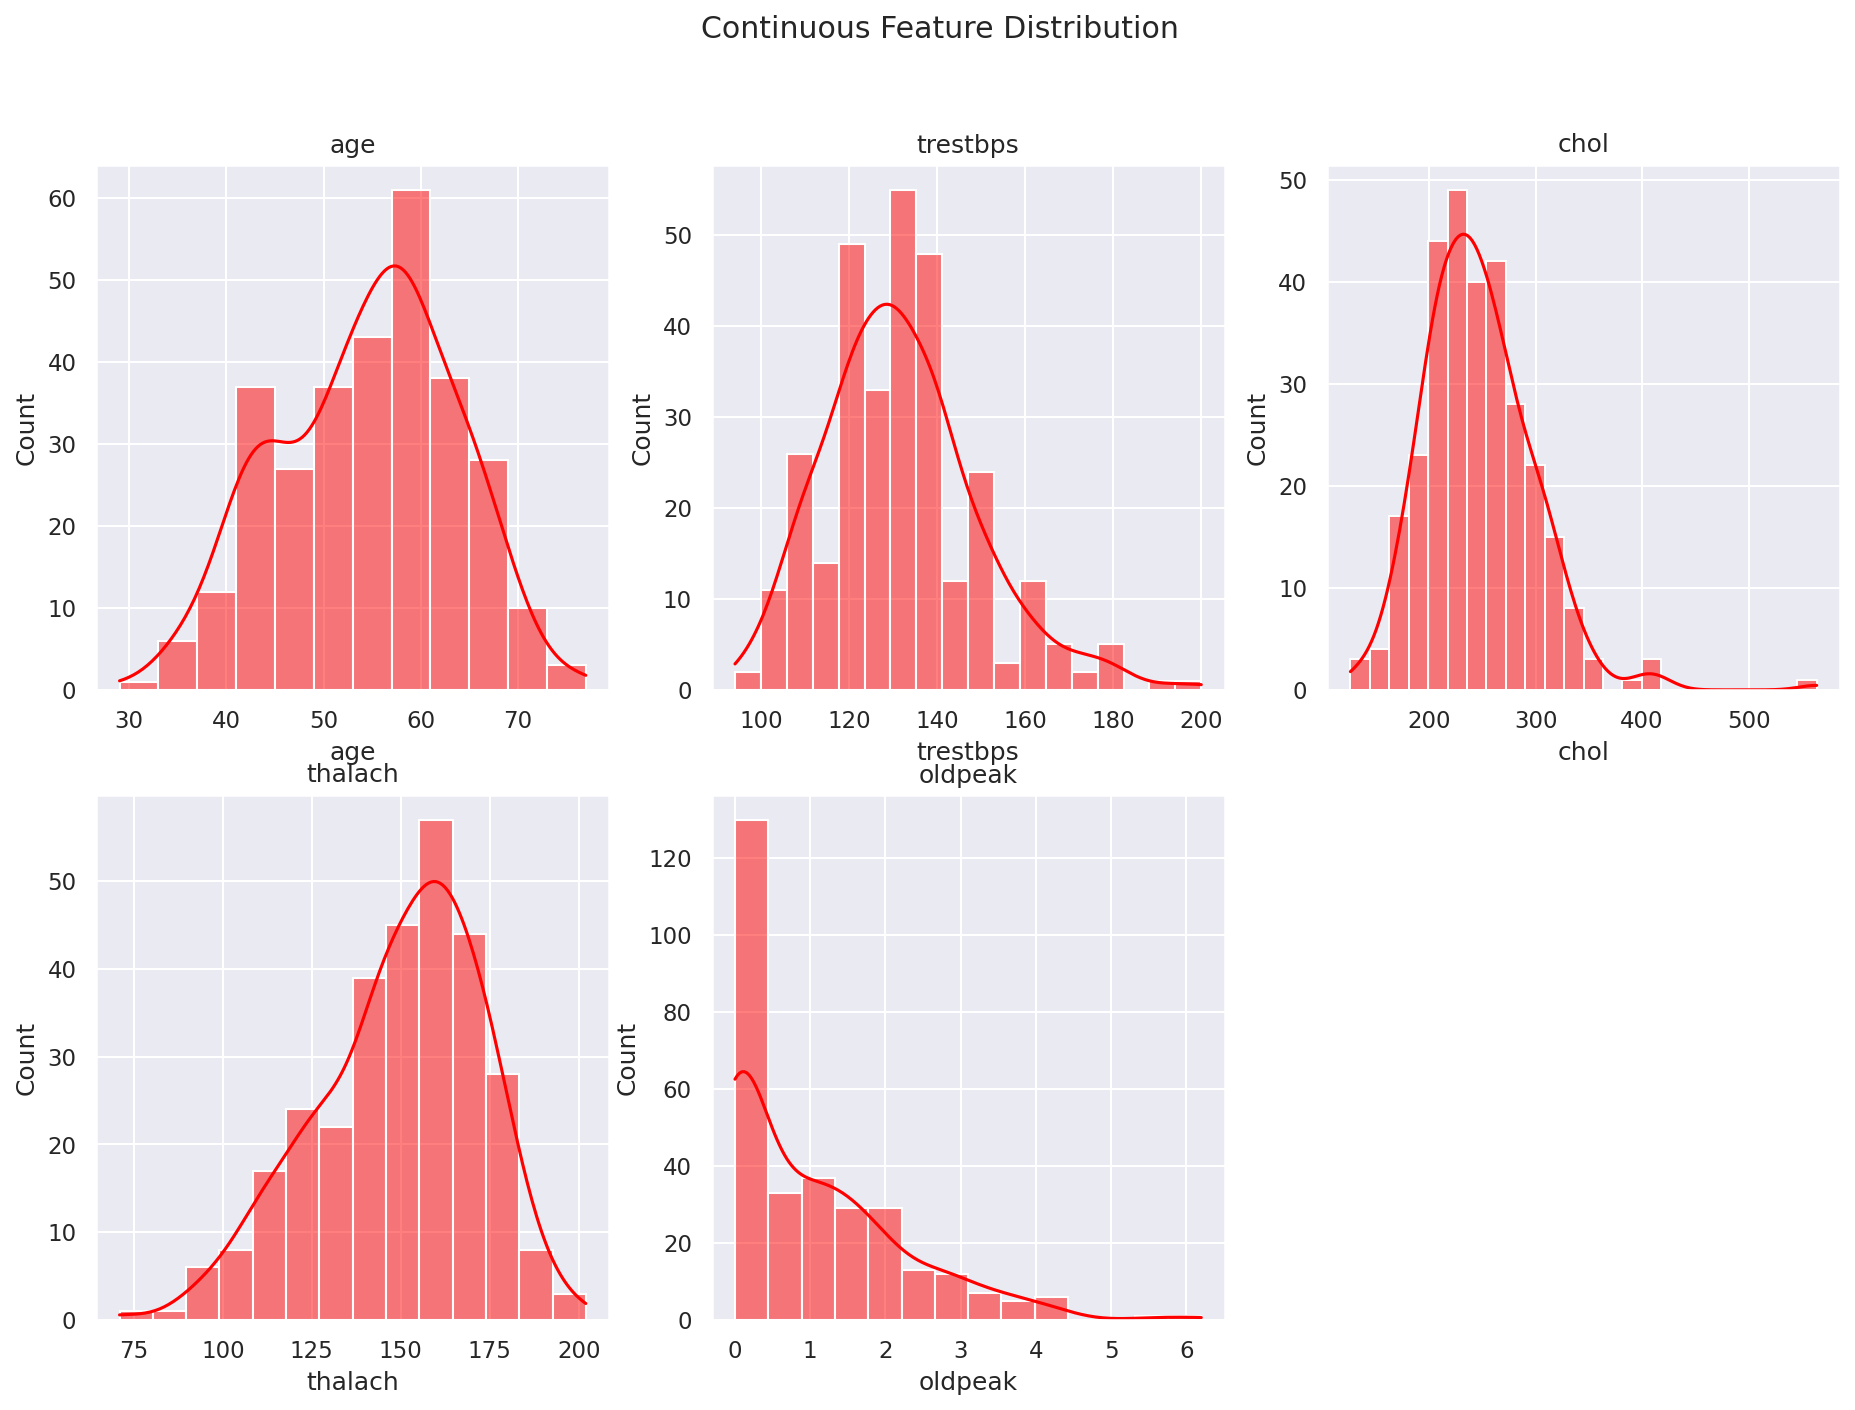

In [45]:
# ===============================
# Continuous Feature Distributions
# ===============================

fig, ax = plt.subplots(2,3, figsize=(15,10))

for i,col in enumerate(continuous_features):

    r = i//3
    c = i%3

    sns.histplot(df[col], kde=True, ax=ax[r,c], color='red')
    ax[r,c].set_title(col)

ax[1,2].axis('off')
plt.suptitle("Continuous Feature Distribution")
plt.show()



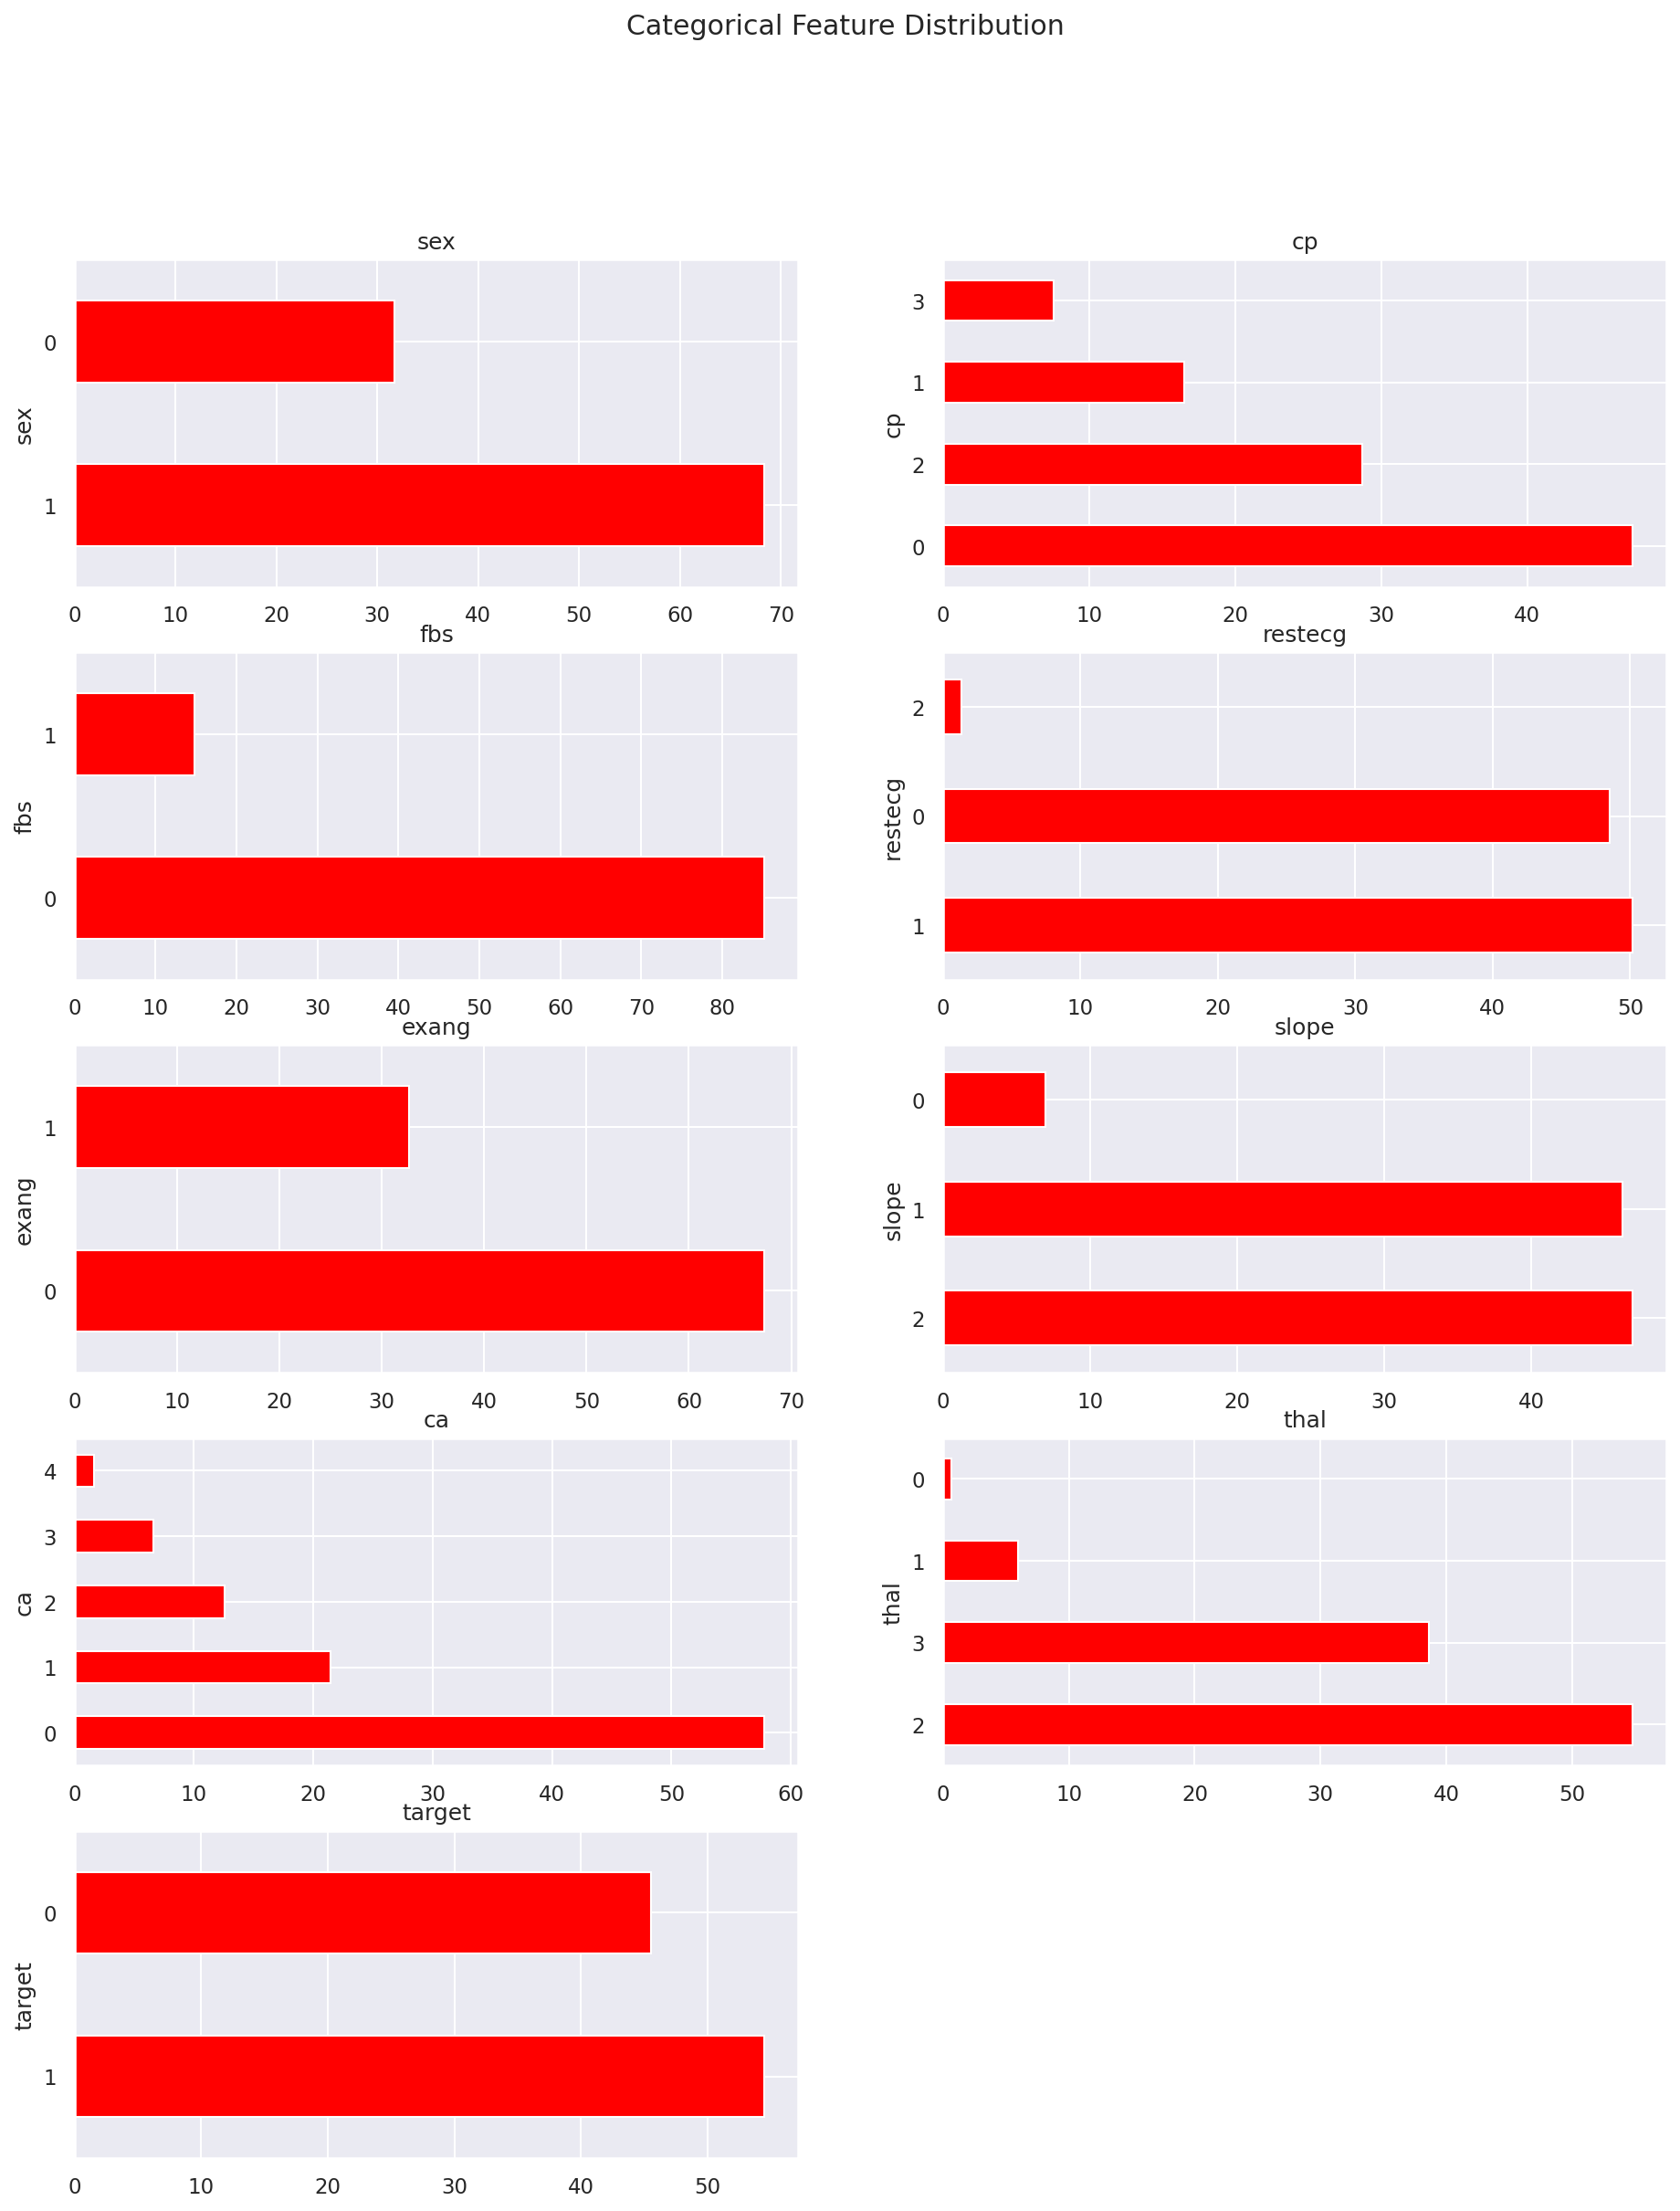

In [46]:
# ===============================
# Categorical Feature Distribution
# ===============================

fig, ax = plt.subplots(5,2, figsize=(15,18))

for i,col in enumerate(categorical_features):

    r = i//2
    c = i%2

    df[col].value_counts(normalize=True).mul(100).plot.barh(
        ax=ax[r,c], color='red'
    )

    ax[r,c].set_title(col)

ax[4,1].axis('off')
plt.suptitle("Categorical Feature Distribution")
plt.show()



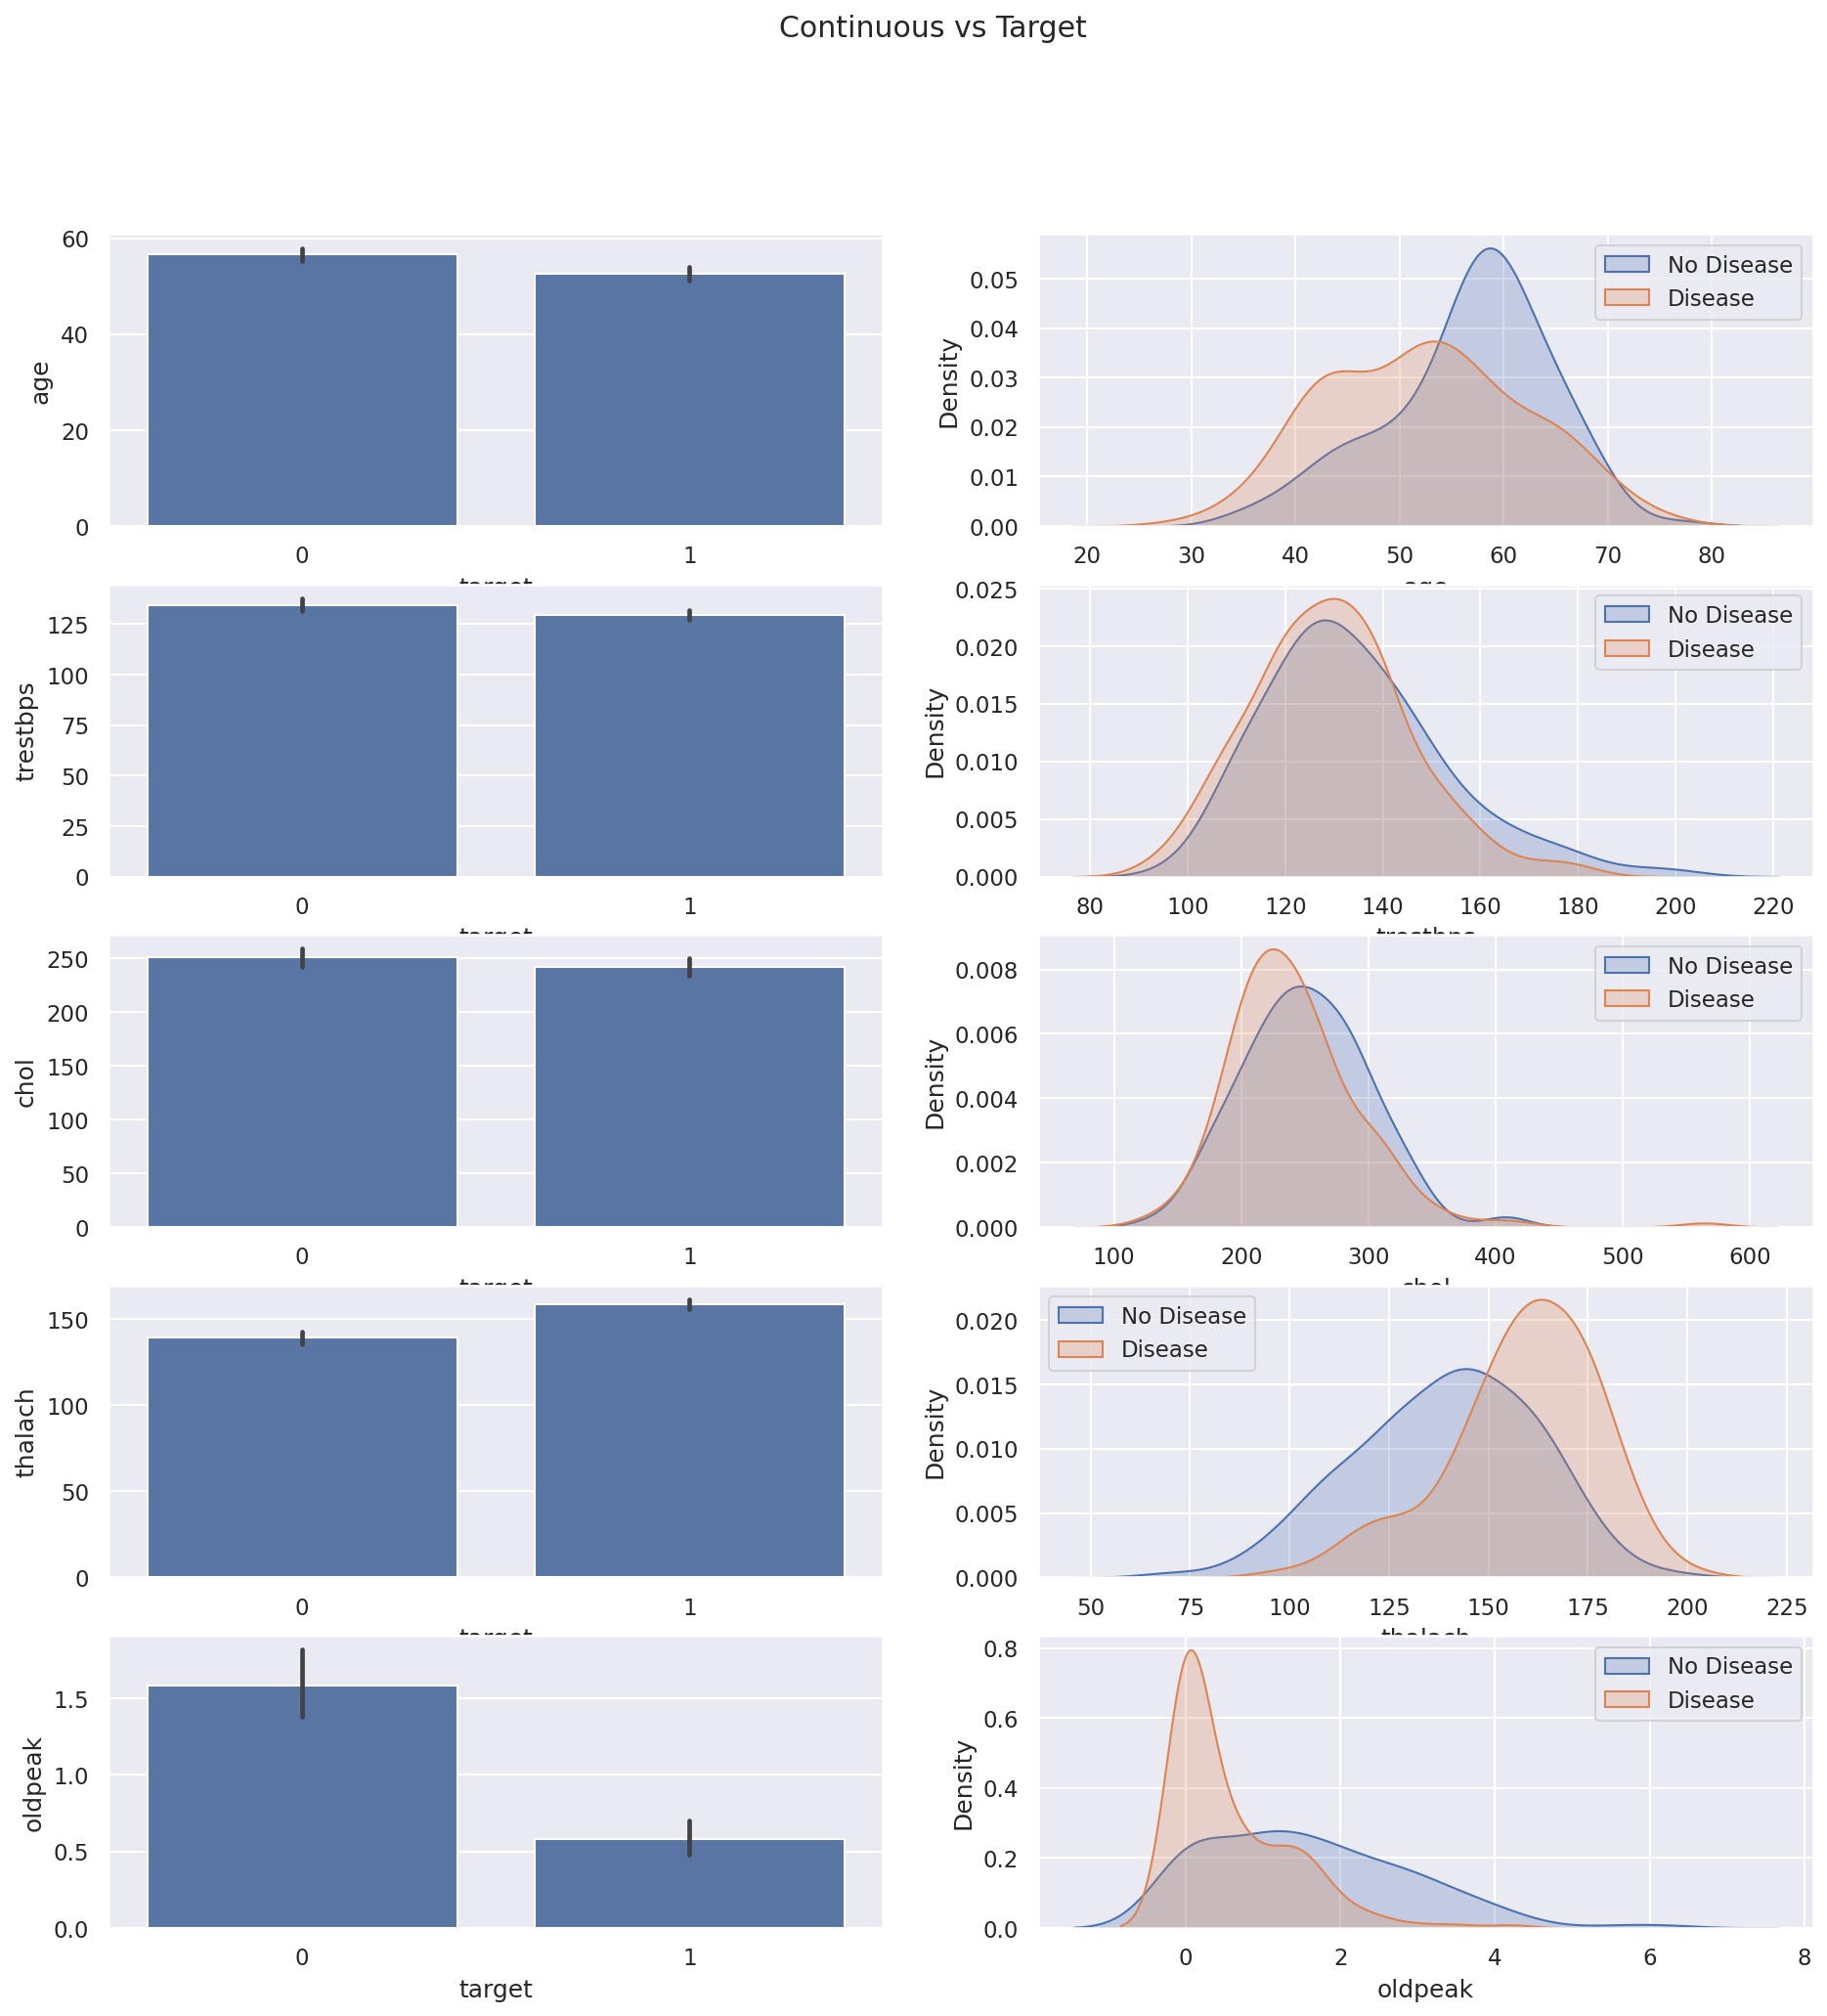

In [47]:
# ===============================
# Continuous vs Target
# ===============================

fig, ax = plt.subplots(len(continuous_features),2, figsize=(15,15))

for i,col in enumerate(continuous_features):

    sns.barplot(data=df, x='target', y=col, ax=ax[i,0])

    sns.kdeplot(df[df['target']==0][col], ax=ax[i,1], label='No Disease', fill=True)
    sns.kdeplot(df[df['target']==1][col], ax=ax[i,1], label='Disease', fill=True)

    ax[i,1].legend()

plt.suptitle("Continuous vs Target")
plt.show()


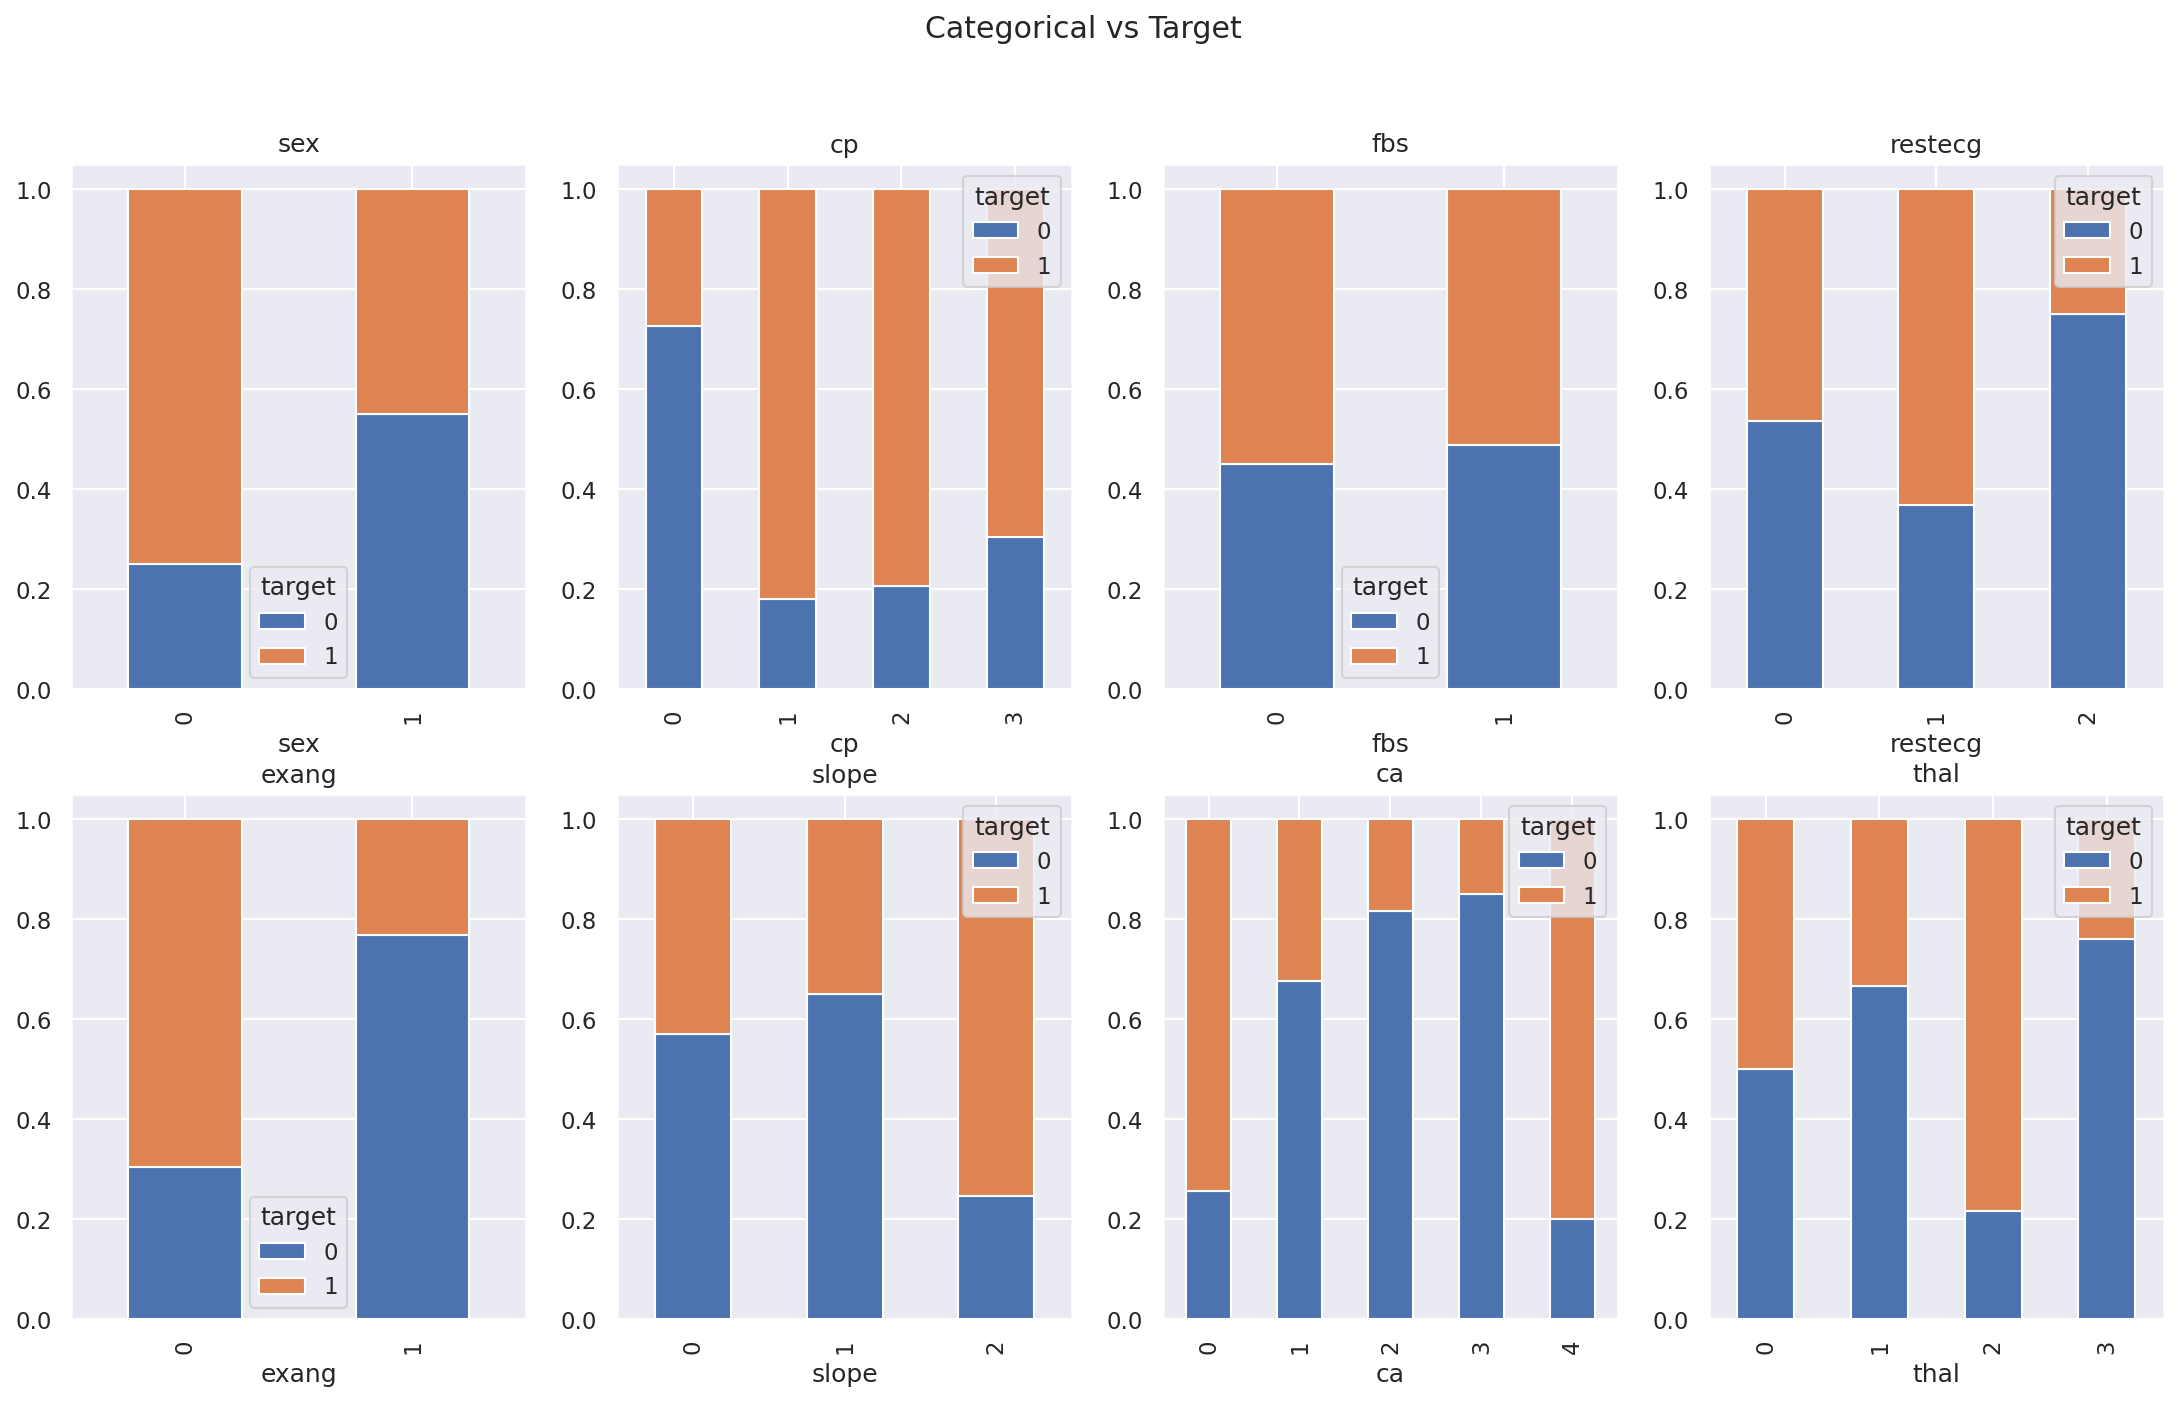

In [48]:
# ===============================
# Categorical vs Target
# ===============================

cat_features = [c for c in categorical_features if c!='target']

fig, ax = plt.subplots(2,4, figsize=(18,10))

for i,col in enumerate(cat_features):

    cross = pd.crosstab(df[col], df['target'], normalize='index')

    r=i//4
    c=i%4

    cross.plot(kind='bar', stacked=True, ax=ax[r,c])

    ax[r,c].set_title(col)

plt.suptitle("Categorical vs Target")
plt.show()


In [49]:
# ===============================
# Encoding
# ===============================

df_encoded = pd.get_dummies(df,
                           columns=['cp','restecg','thal'],
                           drop_first=True)

# Convert remaining
for col in ['sex','fbs','exang','slope','ca','target']:
    df_encoded[col] = df_encoded[col].astype(int)


In [50]:
# ===============================
# Train Test Split
# ===============================

X = df_encoded.drop('target',axis=1)
y = df_encoded['target']

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=42
)



In [51]:
# ===============================
# Boxcox Transformation
# ===============================

X_train['oldpeak'] += 0.001
X_test['oldpeak'] += 0.001

lambdas={}

for col in continuous_features:

    X_train[col], lambdas[col] = boxcox(X_train[col])
    X_test[col] = boxcox(X_test[col],lmbda=lambdas[col])



In [52]:
# ===============================
# Helper: Hyperparameter Tuning
# ===============================

def tune_model(model, param_grid):

    cv = StratifiedKFold(5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring='recall',
        n_jobs=-1
    )

    grid.fit(X_train,y_train)

    return grid.best_estimator_


In [53]:
# ===============================
# Logistic Regression
# ===============================

lr = Pipeline([
    ('scaler',StandardScaler()),
    ('model',LogisticRegression(max_iter=1000))
])

lr.fit(X_train,y_train)

lr_pred = lr.predict(X_test)



In [54]:
# ===============================
# KNN
# ===============================

knn = Pipeline([
    ('scaler',StandardScaler()),
    ('knn',KNeighborsClassifier())
])

knn_params = {
    'knn__n_neighbors':range(1,15),
    'knn__weights':['uniform','distance']
}

best_knn = tune_model(knn,knn_params)

knn_pred = best_knn.predict(X_test)



In [55]:
# ===============================
# Decision Tree
# ===============================

dt = DecisionTreeClassifier()

dt_params = {
    'max_depth':[2,3,4],
    'min_samples_leaf':[1,2]
}

best_dt = tune_model(dt,dt_params)

dt_pred = best_dt.predict(X_test)



In [56]:
# ===============================
# Random Forest
# ===============================

rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators':[100,200],
    'max_depth':[3,4]
}

best_rf = tune_model(rf,rf_params)

rf_pred = best_rf.predict(X_test)


In [57]:
# ===============================
# SVM
# ===============================

svm = Pipeline([
    ('scaler',StandardScaler()),
    ('svm',SVC(probability=True))
])

svm_params = {
    'svm__C':[0.1,1,10],
    'svm__kernel':['linear','rbf']
}

best_svm = tune_model(svm,svm_params)

svm_pred = best_svm.predict(X_test)



In [70]:
# ===============================
# Evaluation Function
# ===============================

def evaluate(y_test, pred, name):

    print(f"\n{name}")
    print("Accuracy:",accuracy_score(y_test,pred))
    print(classification_report(y_test,pred))

    return accuracy_score(y_test,pred)


In [59]:
# ===============================
# Model Evaluation
# ===============================

acc_lr = evaluate(y_test,lr_pred,"Logistic")
acc_knn = evaluate(y_test,knn_pred,"KNN")
acc_dt = evaluate(y_test,dt_pred,"Decision Tree")
acc_rf = evaluate(y_test,rf_pred,"Random Forest")
acc_svm = evaluate(y_test,svm_pred,"SVM")




Logistic
Accuracy: 0.819672131147541
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        28
           1       0.81      0.88      0.84        33

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.82        61
weighted avg       0.82      0.82      0.82        61


KNN
Accuracy: 0.8360655737704918
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        28
           1       0.81      0.91      0.86        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.83        61


Decision Tree
Accuracy: 0.7377049180327869
              precision    recall  f1-score   support

           0       0.73      0.68      0.70        28
           1       0.74      0.79      0.76        33

    accuracy                           0.74        61
   macro avg

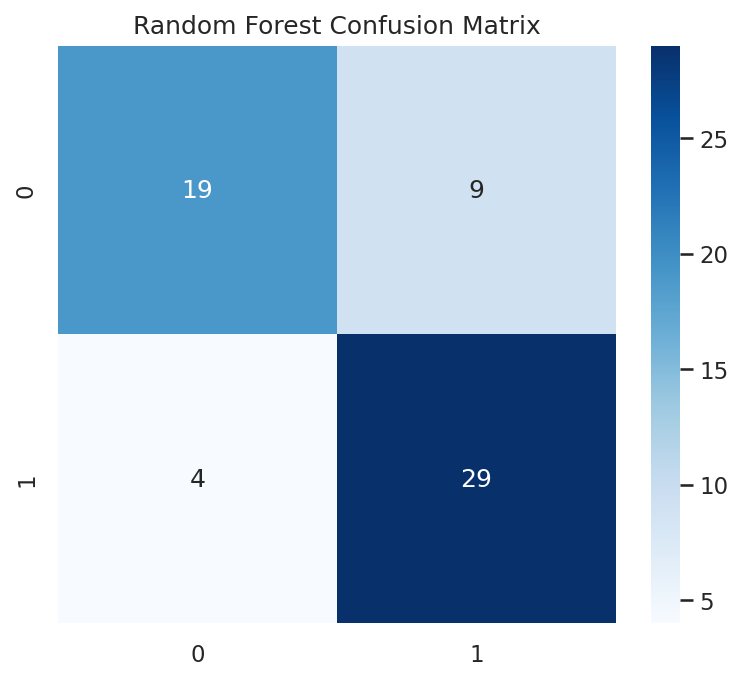

In [60]:
# ===============================
# Confusion Matrix (Best Model = RF)
# ===============================

cm = confusion_matrix(y_test,rf_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()



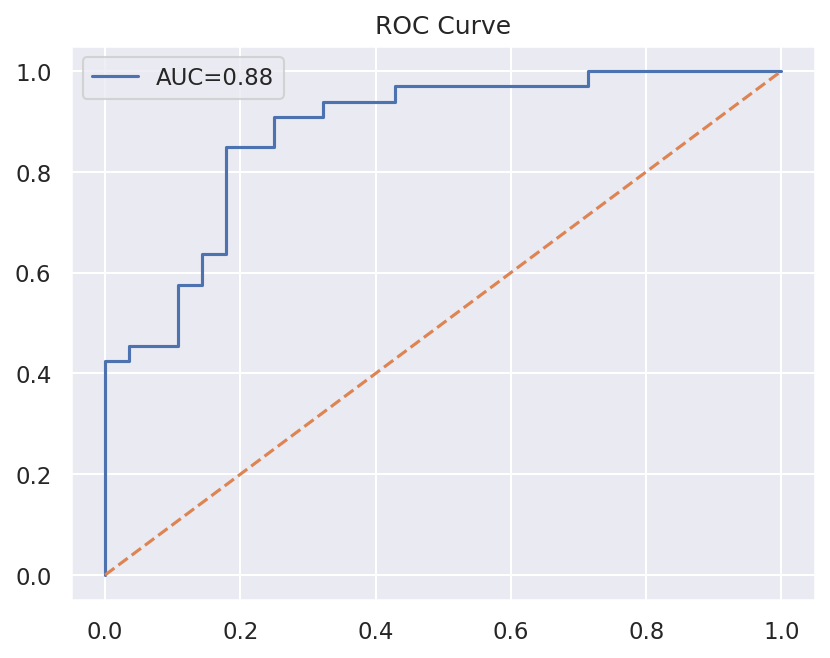

In [61]:
# ===============================
# ROC Curve (Logistic)
# ===============================

probs = lr.predict_proba(X_test)[:,1]

fpr,tpr,_ = roc_curve(y_test,probs)
auc = roc_auc_score(y_test,probs)

plt.plot(fpr,tpr,label=f"AUC={auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve")
plt.show()


  Model  Accuracy
0    LR  0.819672
1   KNN  0.836066
2    DT  0.737705
3    RF  0.786885
4   SVM  0.803279


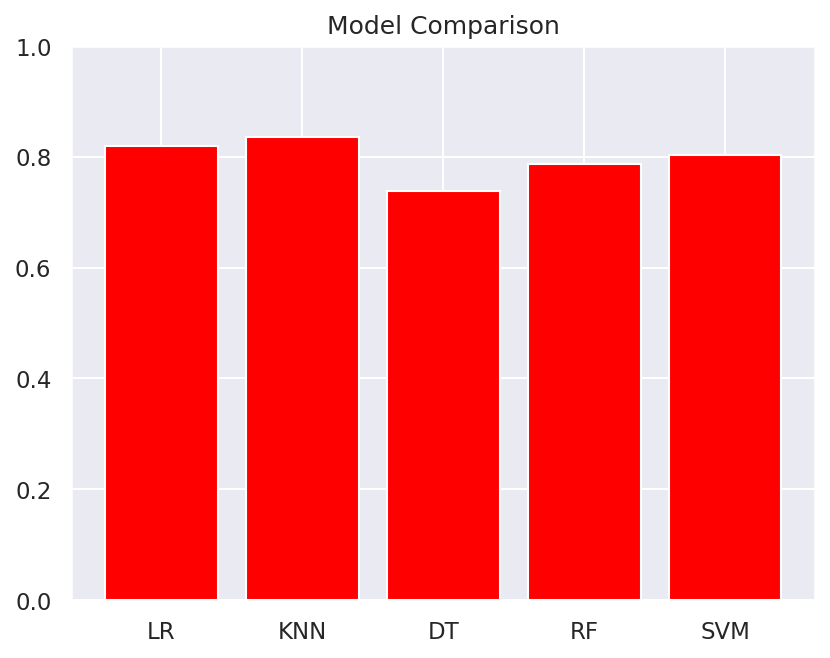

In [62]:
# ===============================
# Model Comparison
# ===============================

results = pd.DataFrame({
    'Model':['LR','KNN','DT','RF','SVM'],
    'Accuracy':[acc_lr,acc_knn,acc_dt,acc_rf,acc_svm]
})

print(results)

plt.bar(results['Model'],results['Accuracy'],color='red')
plt.ylim(0,1)
plt.title("Model Comparison")
plt.show()


In [63]:
# ===============================
# Save Best Model
# ===============================

joblib.dump(best_rf,'heart_model.pkl')

print("Model Saved")


Model Saved


In [82]:
# ===============================
# Prediction Example
# ===============================

sample = (65,0,3,40,2,0,0,30,0,5.0,5,2,1)

sample_df = pd.DataFrame([sample],columns=df.columns[:-1])

sample_df = pd.get_dummies(sample_df)
sample_df = sample_df.reindex(columns=X.columns, fill_value=0)

pred = best_rf.predict(sample_df)

# Get probability of heart disease (class = 1)
prob = best_rf.predict_proba(sample_df)[0][1]

# Convert to percentage
risk_percent = prob * 100

# Display result
if pred[0] == 1:
    print(f"⚠️ High Risk of Heart Disease ({risk_percent:.2f}%)")
else:
    print(f"✅ Low Risk of Heart Disease ({risk_percent:.2f}%)")

✅ Low Risk of Heart Disease (42.71%)
